## Library

In [ ]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import numpyro
import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan
from tqdm import tqdm
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)


In [ ]:
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])


# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = (1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)


data_N_hat_annual = pd.read_csv("data/BN_filter_user_inputted_series_results_HHI.csv")
data_N_hat_annual["year"] = (
    pd.to_datetime(data_N_hat_annual["date"])   # ①
      .dt.year                                  # ②
)
data_N_hat_annual['DATE'] = pd.to_datetime(data_N_hat_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_hat_annual = data_N_hat_annual.set_index('DATE')
data_N_hat = data_N_hat_annual.resample('QS').asfreq()
data_N_hat = data_N_hat.reset_index()
data_N_hat['N_hat_BN'] = data_N_hat['cycle'].interpolate(method='linear')
data_N_hat["original_series"] = data_N_hat['original_series'].interpolate(method='linear')
data_N_hat["N_trend_BN"] = data_N_hat['trend'].interpolate(method='linear')
data_N_hat = data_N_hat[["DATE", "N_hat_BN", "N_trend_BN"]]

# # data_N
# data_Nb = pd.read_csv("data/BDSTIMESERIES.BDSGEO-2025-02-26T120133.csv")
# data_Nb = data_Nb[["Year (time)", "Number of firms (FIRM)"]]
# data_Nb['year'] = pd.to_datetime(data_Nb['Year (time)'], format='%Y') + pd.offsets.YearBegin(0)
# data_Nb = data_Nb.set_index('year')
# data_Nb = data_Nb[["Year (time)", "Number of firms (FIRM)"]].copy()
# data_Nb["N"] = pd.to_numeric(data_Nb["Number of firms (FIRM)"].str.replace(",", ""), errors="coerce")
# data_Nb = data_Nb.resample('QS').asfreq()
# data_Nb['Nb'] = np.log(data_Nb['N'].interpolate(method='linear'))
# data_Nb = data_Nb.reset_index()
# data_Nb['DATE'] = pd.to_datetime(data_Nb['year'])
# data_Nb = data_Nb[["DATE", "Nb"]]

data_Nb = pd.read_csv("data/BLS-bd-BDS0000000000000000120007LQ5.csv")
data_Nb["N_end"] = data_Nb["National – Establishment Births – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120007LQ5)"]
data_Nb["Nb"] = data_Nb["N_end"] * 1000
data_Nb['q'] = data_Nb["period"]
data_Nb["q"] = data_Nb["q"].str.replace(" ", "")
data_Nb["DATE"] = data_Nb["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nb = data_Nb[["DATE", "Nb"]]
data_Nd = pd.read_csv("data/BLS-bd-BDS0000000000000000120008LQ5.csv")
data_Nd["N_end"] = data_Nd["National – Establishment Deaths – Number of Establishments – Total private – National – Private Sector – Quarterly – Level – Seasonally Adjusted – All size classes – U.S. totals – Establishment (BLS/bd/BDS0000000000000000120008LQ5)"]
data_Nd["Nd"] = data_Nd["N_end"] * 1000
data_Nd['q'] = data_Nd["period"]
data_Nd["q"] = data_Nd["q"].str.replace(" ", "")
data_Nd["DATE"] = data_Nd["q"].apply(lambda x: pd.Period(x, freq="Q").start_time)
data_Nd = data_Nd[["DATE", "Nd"]]
data_Nb = pd.merge(data_Nb, data_Nd, on = "DATE")
data_Nb = data_Nb.dropna()
data_Nb["Nchange"] = data_Nb["Nb"] - data_Nb["Nd"]
data_Nb = data_Nb[data_Nb["DATE"] >= "1993-04-01"]
initial_value = 5387024
data_Nb["Nb"] = initial_value + data_Nb["Nchange"].shift(fill_value=0).cumsum()
data_Nb["Nb"] = np.log(data_Nb["Nb"])
data_Nb = data_Nb[["DATE", "Nb"]]

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_Nb, on="DATE", how="outer")
data = pd.merge(data, data_N_hat, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data = data.dropna()


# for MCMC
pi = jnp.array(data['pi'],dtype=jnp.float64)
pi_prev = jnp.array(data['pi_prev'],dtype=jnp.float64)
pi_expect = jnp.array(data['Epi'],dtype=jnp.float64)
N = jnp.array(data['N'],dtype=jnp.float64)
# Nb = jnp.array(data['Nb'],dtype=jnp.float64)
Y = jnp.array(data['output'],dtype=jnp.float64)

x_markup = jnp.array(1/data['markup'],dtype=jnp.float64)
x_outputgap = jnp.array(data['output_gap_BN'],dtype=jnp.float64)
x_output_gap_prev = jnp.array(data['output_gap_prev'],dtype=jnp.float64)
x_markup_prev = jnp.array(1/data['markup_prev'],dtype=jnp.float64)

# N_hat = jnp.array(data["N_hat"], dtype=jnp.float64)


## Estimation

NKPC under HSA

Rotemberg

$$
\hat{\pi}_{t}=\beta\left(1-\delta\right)\mathbb{E}_{t}\hat{\pi}_{t+1}+\overset{\text{steady-state effect}}{\overbrace{\frac{\zeta\left(z\right)-1}{\chi}}}\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{p}_{t}\right)-\overset{\text{dynamic effect}}{\overbrace{\frac{1}{\chi}\frac{1-\rho\left(z\right)}{\rho\left(z\right)}\hat{N}_{t}}}
$$


Calvo
$$
\hat{\tilde{\pi}}_{t}	=	\beta\left(1-\delta\right)\mathbb{E}_{t}\hat{\tilde{\pi}}_{t+1}+\overset{\text{steady-state effect}}{\overbrace{\frac{\left(1-\phi\right)\left[1-\phi\beta\left(1-\delta\right)\right]}{\phi}\rho\left(\tilde{z}\right)}}\left(\hat{W}_{t}-\hat{Z}_{P,t}-\hat{\tilde{p}}_{t}\right)
		-\overset{\text{dynamic effect}}{\overbrace{\frac{\left(1-\phi\right)\left[1-\phi\beta\left(1-\delta\right)\right]}{\phi}\left(1-\rho\left(\tilde{z}\right)\right)\hat{N}_{t}}}.
$$
Note that $s\left(z_{t}\right)=\frac{1}{N_{t}}$.

Estimation strategy

$N_{t}$ denotes the measure of the number of firms (varieties), or the inverse of concentration, and $x_{t}$ denotes the measure of the output gap or the inverse of the markup.


# Prior distribution
| NKPC Parameters      | | 
|--------------- |--------------------|
| **$\alpha$**      | Uniform&nbsp;(0, 1) | 
|**$\kappa$**      | Uniform&nbsp;(0, 1) | 
|**$\theta$**      | Uniform&nbsp;(0, 1) | 
|**$\sigma_v$**    | LogNormal&nbsp;(0, 1) |

| AR Parameters | Prior / Definition | Notes |
|-----------|--------------------|-------|
| **$r_{\hat{N}}$** , **$r_{\hat{x}}$**    | Uniform&nbsp;(-1,&nbsp;1) | Magnitude of complex root for AR(2) |
| **$p_{\hat{N}}$** , **$p_{\hat{x}}$**     | Uniform&nbsp;(0.1,&nbsp;0.9) | Phase (fraction of π) for AR(2) |

| $\hat{N}$ Parameters      | | $\hat{N}$ hat with z Parameters| | $\hat{x}$ Parameters      | |
|--------------- |--------------------| --------------- |--------------------|--------------- |--------------------| 
| **$\rho_1$**     | $2r_{\hat{N}}cos(π p_{\hat{N}})$ |  **$\theta_{N,1}$**    | $2r_{\hat{N}}cos(π p_{\hat{N}})$ |**$\nu_1$**     |  $2r_{\hat{x}}cos(π p_{\hat{x}})$|  
|**$\rho_2$**      | $-r_{\hat{N}}^2$ |  **$\theta_{N,2}$**    | $-r_{\hat{N}}^2$ |**$\nu_2$**      | $-r_{\hat{x}}^2$ |  
|**$\delta$**      | Normal&nbsp;(0, 0.5) |  **$\theta_{\pi}$**    | Normal&nbsp;(0, 0.5) |**$\sigma$**      | Normal&nbsp;(0, 0.5) | 
|**$\phi$**      | Uniform&nbsp;(0, 1) | **$\theta_{x}$**    | Uniform&nbsp;(0, 1) |**$\beta$**      | Uniform&nbsp;(0, 1) |
|**$\sigma_u$**    | LogNormal&nbsp;(0, 0.1) |**$\sigma_u$**    | LogNormal&nbsp;(0, 0.1) |**$\sigma_\omega$**    | LogNormal&nbsp;(0, 0.1) |

| $\bar{N}$ Parameters      | |$\bar{y}$ Parameters      | | 
|--------------- |--------------------| --------------- |--------------------|
| **n**     | Normal&nbsp;(0, 0.5) |   **g**     | Normal&nbsp;(0, 0.5) |
|**$\sigma_\epsilon$**    | LogNormal&nbsp;(0, 1) |  **$\sigma_\chi$**    | LogNormal&nbsp;(0, 1) |

| $\kappa$ Parameters      | |
|--------------- |--------------------|
| **$\eta$**     | Beta&nbsp;(0, 1) |
| **$\psi$**     | Betam&nbsp;(0, 1) |
| **$\sigma_\mu$**     | LogNormal&nbsp;(0, 1) |

In [ ]:
warmup= 5000
samples=  10000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)


def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Gamma(2,2),
        "kappa"      : dist.Gamma(2,2), 
        "theta"      : dist.Gamma(2,2), 
        # N hat params
        "theta_z"    : dist.Gamma(2,2),
        "theta_N"    : dist.Normal(0, 1), 
        "theta_pi"   : dist.Normal(0, 1), 
        "theta_x"    : dist.Normal(0, 1), 
        "delta"      : dist.Normal(0, 1), 
        "phi"        : dist.Gamma(2,2),
        # kappa params
        "eta"        : dist.Gamma(2,2),
        "psi"        : dist.Gamma(2,2),
        # bar params 
        "n"          : dist.Gamma(2,2),
        "g"          : dist.Gamma(2,2),
        # initial
        "z_init"     : dist.Normal(0.5, 1), 
        "kappa_init" : dist.Normal(0.5, 1), 
        # Sigma
        "sigma_u"    : dist.LogNormal(0,1),  
        "sigma_eps"  : dist.LogNormal(0,1),  
        "sigma_omega": dist.LogNormal(0,1),  
        "sigma_chi"  : dist.LogNormal(0,1),  
        "sigma_v"    : dist.LogNormal(0,1),
        "sigma_mu"   : dist.LogNormal(0,1),
        "sigma_e"    : dist.LogNormal(0,0.1),  
    }
    return priors


---
---
Normal NKPC
$$
\pi_{t}=\alpha\pi_{t-1}+\left(1-\alpha\right)\mathbb{E}_{t}\pi_{t-1}+\kappa x_{t}+v_{t},
$$

In [ ]:
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

# Normal NKPC
print("Normal NKPC")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup)
idata_0_m = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
diverging  = idata_0_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                             # mean of 0/1 booleans = share of divergences
print(f"model 0: divergence ratio = {ratio_div:.4%}")     # bool for each param

dict_idata = {'Normal NKPC/ markup':idata_0_m}

params = ["alpha", "kappa", "sigma_v"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)



Normal NKPC


sample: 100%|██████████| 15000/15000 [00:02<00:00, 6987.63it/s, 15 steps of size 1.51e-01. acc. prob=1.00]


model 0: divergence ratio = 0.0000%


,model,alpha,kappa,sigma_v
0,Normal NKPC/ markup,0.122,0.082,0.443


---
---

No shift in the slope
$$
\pi_{t}=\alpha\pi_{t-1}+\left(1-\alpha\right)\mathbb{E}_{t}\pi_{t-1}+\kappa x_{t}-\theta\hat{N}_{t}+v_{t},
$$
where
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
$$
\hat{N}_{t}=\rho_1 \hat{N}_{t-1}+\rho_2 \hat{N}_{t-2}+\delta\pi_{t-1}+\phi x_{t-1}+u_{t}
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\varepsilon_{t},
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)  \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2),
$$


---
Shift in the slope

$$
\pi_{t}=\alpha\pi_{t-1}+\left(1-\alpha\right)\mathbb{E}_{t}\pi_{t-1}+\kappa_{t}x_{t}-\theta\hat{N}_{t}+v_{t},
$$

where
$$
N_{t}=\bar{N}_{t}+\hat{N}_{t},
$$
$$\hat{N}_{t}=\rho_1\hat{N}_{t-1}+\rho_2\hat{N}_{t-2}+\delta\pi_{t-1}+\phi x_{t-1}+u_{t},
$$
$$
\bar{N}_{t}=n+\bar{N}_{t-1}+\varepsilon_{t},
$$
$$
\kappa_{t}= \eta \kappa_{t-1} - \psi\bar{N}_{t} + e_{t}.
$$
$$
v_t \sim \mathcal{N}(0, \sigma_{v}^2)  \quad u_t \sim \mathcal{N}(0, \sigma_{u}^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2), \quad e_t \sim \mathcal{N}(0, \sigma_{e}^2)
$$

In [ ]:
def model_1(pi, pi_prev, pi_expect, x, x_prev, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    
    phi = numpyro.sample("phi", priors["phi"])
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t  = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2 + delta * pi_prev[t] + phi * x_prev[t]
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)


def model_2(pi, pi_prev, pi_expect, x, x_prev, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    phi = numpyro.sample("phi", priors["phi"])
    delta = numpyro.sample("delta", priors["delta"])
    r = numpyro.sample("r", dist.Uniform(-1,1))      # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    psi = numpyro.sample("psi", priors["psi"])
    eta = numpyro.sample("eta", priors["eta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])         
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"])
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        # trend 
        Nbar_t  = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # kappa
        kappa_t = numpyro.sample(f"kappa", dist.TruncatedNormal(loc= eta * kappa_prev - psi * Nbar_t, scale=sigma_e, low=0))
        # kappa_t = numpyro.deterministic("kappa", eta * kappa_prev - psi * Nbar_t)
        # Nbar + Nhat = observed N
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2 + delta * pi_prev[t] + phi * x_prev[t]
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)

In [ ]:
# RUN MCMC
print("HSA NKPC : x = markup , no shift in slope")
# model 1
kernel = NUTS(model_1, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi, pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup, x_prev=x_markup_prev, N = N, l=len(pi))
idata_1_m = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_1_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_1_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_1_m = N_bar_mean_1_m - 1.97 * N_bar_std_1_m
N_bar_upper_1_m = N_bar_mean_1_m + 1.97 * N_bar_std_1_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_1_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_1_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_1_m = N_hat_mean_1_m - 1.97 * N_hat_std_1_m
N_hat_upper_1_m = N_hat_mean_1_m + 1.97 * N_hat_std_1_m

diverging  = idata_1_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1 : divergence ratio = {ratio_div:.4%}")

# model 2
print("HSA NKPC : x = markup , shift in slope")
kernel = NUTS(model_2, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi,pi_prev=pi_prev, pi_expect=pi_expect, x=x_markup,x_prev=x_markup_prev, N=N, l=len(pi))
idata_2_m = az.from_numpyro(mcmc)

# Results
posterior_samples = mcmc.get_samples()
N_bar_samples = posterior_samples["Nbar"]
N_bar_mean_2_m = np.mean(N_bar_samples, axis=0) 
N_bar_std_2_m = np.std(N_bar_samples, axis=0)  
N_bar_lower_2_m = N_bar_mean_2_m - 1.97 * N_bar_std_2_m
N_bar_upper_2_m = N_bar_mean_2_m + 1.97 * N_bar_std_2_m
N_hat_samples = posterior_samples["Nhat"]
N_hat_mean_2_m = np.mean(N_hat_samples, axis=0) 
N_hat_std_2_m = np.std(N_hat_samples, axis=0)  
N_hat_lower_2_m = N_hat_mean_2_m - 1.97 * N_hat_std_2_m
N_hat_upper_2_m = N_hat_mean_2_m + 1.97 * N_hat_std_2_m
kappa_samples = posterior_samples["kappa"]
kappa_mean_2_m = np.mean(kappa_samples, axis=0) 
kappa_std_2_m = np.std(kappa_samples, axis=0)  
kappa_lower_2_m = kappa_mean_2_m - 1.97 * kappa_std_2_m
kappa_upper_2_m = kappa_mean_2_m + 1.97 * kappa_std_2_m

diverging  = idata_2_m.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 2 : divergence ratio = {ratio_div:.4%}")

dict_idata = {
    'Normal NKPC / markup':idata_0_m, 'HSA NKPC no-shift / markup':idata_1_m, 'HSA NKPC shift / markup':idata_2_m, 
    }

params = [
    "alpha", "kappa", "theta", "rho_1","rho_2", "phi", 'delta' , "eta", "psi" ,  "n"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

# --------------------------------------------------------
# Combined Figure for Model Plots
# --------------------------------------------------------
scale = 2
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=False)

# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data["DATE"], data["N"], N_bar_mean_1_m, N_hat_mean_1_m,
    "N: MCMC decomposition no-shift: AR2, X=Markup", loc="lower right"
)

# Second decomposition: with shift
plot_decomposition_ax(
    axes[1],
    data["DATE"], data["N"], N_bar_mean_2_m, N_hat_mean_2_m,
    "N: MCMC decomposition shift: AR2, X=Markup", loc="lower right"
)
# Final layout
axes[2].plot(data["DATE"], kappa_mean_2_m, label="HSA AR2 / markup", color=colors[0])
axes[2].set_title("Estimated kappa shift")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("kappa_t")
axes[2].legend()
axes[2].set_ylim(0, 0.2)
axes[2].minorticks_on()
axes[2].grid(which='major', linestyle='-', linewidth=0.75)
axes[2].grid(which='minor', linestyle=':', linewidth=0.5)
axes[2].xaxis.set_major_locator(mdates.YearLocator(5))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[2].xaxis.set_minor_locator(mdates.YearLocator(1))

plt.tight_layout()
plt.show()

HSA NKPC : x = markup , no shift in slope


  0%|          | 0/15000 [00:03<?, ?it/s]


KeyboardInterrupt: 

## Model Comparison

WAIC（Widely Applicable Information Criterion, Watanabe Akaike Information Criterion）is calculated by:
$$
\text{WAIC}=-2\Bigl(\text{lppd}-p_{\text{WAIC}}\Bigr)
$$
where
- log pointwise predictive density
$$
\text{lpd}=\sum_{i=1}^{n}\log\Biggl(\frac{1}{S}\sum_{s=1}^{S}p\Bigl(y_{i}\mid\theta^{(s)}\Bigr)\Biggr)
$$
This term measures the average fit of the model across all posterior draws. It’s like the average log-likelihood, but averaged over the posterior.
- effective number of parameters
$$
p_{\text{WAIC}}=\sum_{i=1}^{n}Var_{\theta}\Bigl(\log p\bigl(y_{i}\mid\theta\bigr)\Bigr)
$$
This captures how much the log-likelihood varies across posterior samples for each data point. High variance means the model is more complex (more sensitive to the choice of parameters), so it penalizes complexity.

,model,alpha,kappa,theta,theta_N,theta_pi,theta_x,rho_1,rho_2,n,eta,psi,phi,delta
0,Normal NKPC,0.122,0.082,-,-,-,-,-,-,-,-,-,-,-
1,HSA NKPC no-shift,0.123,0.177,0.066,-,-,-,1.788,-0.886,0.053,-,-,0.223,0.018
2,HSA NKPC shift,0.121,-,0.056,-,-,-,1.788,-0.887,0.054,0.947,0.611,0.223,0.018


<Axes: title={'center': 'Model comparison\nlower is better'}, xlabel='elpd_waic (deviance)', ylabel='ranked models'>

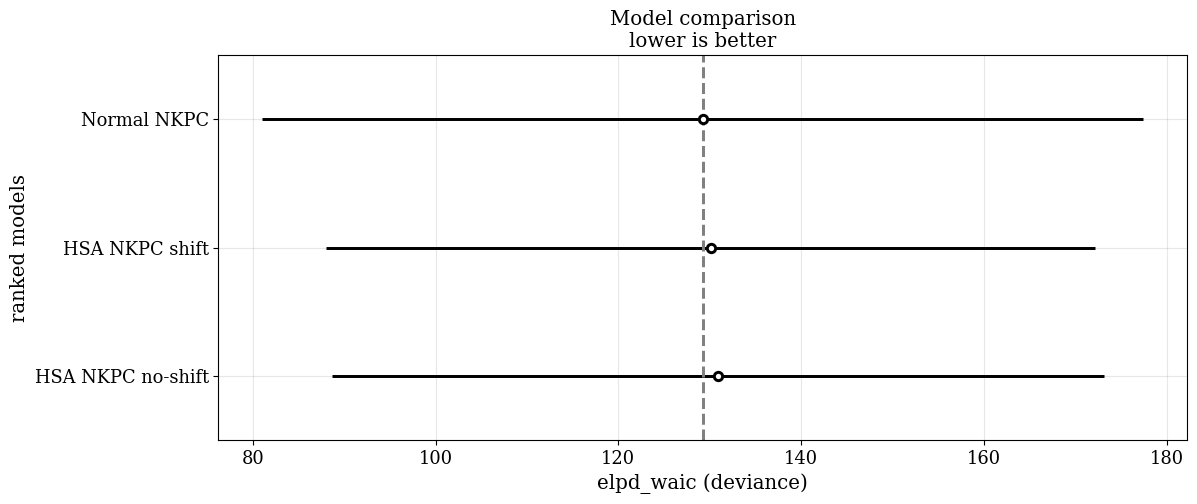

In [ ]:
dict_idata = {
    'Normal NKPC':idata_0_m, 'HSA NKPC no-shift':idata_1_m, 'HSA NKPC shift':idata_2_m, 
    }

params = [
    "alpha", "kappa", "theta", "theta_N", 'theta_pi' , "theta_x" , "rho_1", "rho_2",  "n", "eta", "psi", "phi","delta"
    ]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
scale = 5  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))